In [1]:
import os
import random
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import pandas as pd

In [14]:
base_dir = r"D:\Random_Projects\IDCamp\Proyek 2"
categories = ["cat", "dog", "spider"]
category_counts = {category: len(os.listdir(os.path.join(base_dir, category))) for category in categories}
print("Initial Image Counts:", category_counts)
min_count = min(category_counts.values())
print(f"Balancing dataset to {min_count} images per category")

Initial Image Counts: {'cat': 4705, 'dog': 7790, 'spider': 4821}
Balancing dataset to 4705 images per category


In [ ]:
#Create balanced dataset folder to train a CNNmodel
balanced_dir = os.path.join(base_dir, "balanced")
os.makedirs(balanced_dir, exist_ok=True)
for category in categories:
    source_path = os.path.join(base_dir, category)
    dest_path = os.path.join(balanced_dir, category)
    os.makedirs(dest_path, exist_ok=True)
    selected_files = random.sample(os.listdir(source_path), min_count)
    for file in selected_files:
        shutil.copy2(os.path.join(source_path, file), os.path.join(dest_path, file))
print("Dataset balanced!")

Dataset balanced!


In [6]:
#Split into train, val, test (80:10:10, try different ratios later)
split_ratios = {"train": 0.8, "val": 0.1, "test": 0.1}
split_dirs = {key: os.path.join(base_dir, key) for key in split_ratios}

for key in split_dirs.values():
    os.makedirs(key, exist_ok=True)
    for category in categories:
        os.makedirs(os.path.join(key, category), exist_ok=True)

for category in categories:
    files = os.listdir(os.path.join(balanced_dir, category))
    random.shuffle(files)
    train_split = int(split_ratios["train"] * min_count)
    val_split = int(split_ratios["val"] * min_count)
    train_files = files[:train_split]
    val_files = files[train_split:train_split + val_split]
    test_files = files[train_split + val_split:]
    
    for split, split_files in zip(["train", "val", "test"], [train_files, val_files, test_files]):
        for file in split_files:
            shutil.copy2(os.path.join(balanced_dir, category, file), os.path.join(base_dir, split, category, file))
print("Train, Val, Test split completed!")

Train, Val, Test split completed!


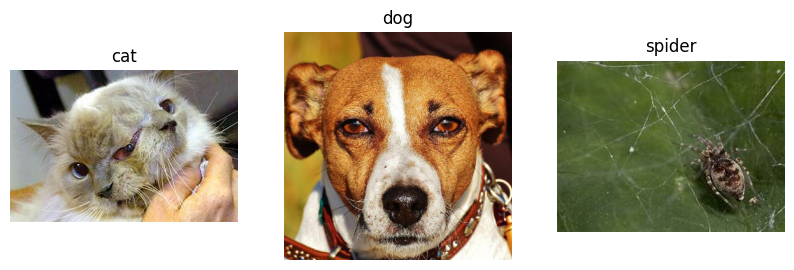

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
for ax, category in zip(axes, categories):
    sample_image = random.choice(os.listdir(os.path.join(base_dir, "train", category)))
    img = plt.imread(os.path.join(base_dir, "train", category, sample_image))
    ax.imshow(img)
    ax.set_title(category)
    ax.axis("off")

plt.show()

In [ ]:
#Image Resolutions Used
train_dir = r"D:\Random_Projects\IDCamp\Proyek 2\train"
image_data = []

for category in ["cat", "dog", "spider"]:
    category_path = os.path.join(train_dir, category)
    
    for file in os.listdir(category_path):
        img_path = os.path.join(category_path, file)
        img = cv2.imread(img_path)
        
        if img is not None:
            height, width, _ = img.shape
            image_data.append({"Category": category, "Filename": file, "Width": width, "Height": height})

imageSizeDf = pd.DataFrame(image_data)
print(imageSizeDf.head())
print(imageSizeDf.groupby("Category")[["Width", "Height"]].describe())

  Category   Filename  Width  Height
0      cat     1.jpeg    300     210
1      cat   100.jpeg    150     150
2      cat  1002.jpeg    200     300
3      cat  1004.jpeg    300     200
4      cat  1005.jpeg    300     200
           Width                                                              \
           count        mean         std    min    25%    50%    75%     max   
Category                                                                       
cat       3764.0  494.856536  395.250717  107.0  300.0  512.0  512.0  6720.0   
dog       3764.0  369.734591  113.923610  137.0  300.0  300.0  512.0   512.0   
spider    3764.0  309.135494   85.357538   88.0  300.0  300.0  300.0   640.0   

          Height                                                              
           count        mean         std    min    25%    50%    75%     max  
Category                                                                      
cat       3764.0  458.828640  312.780160   75.0  300.0  512.

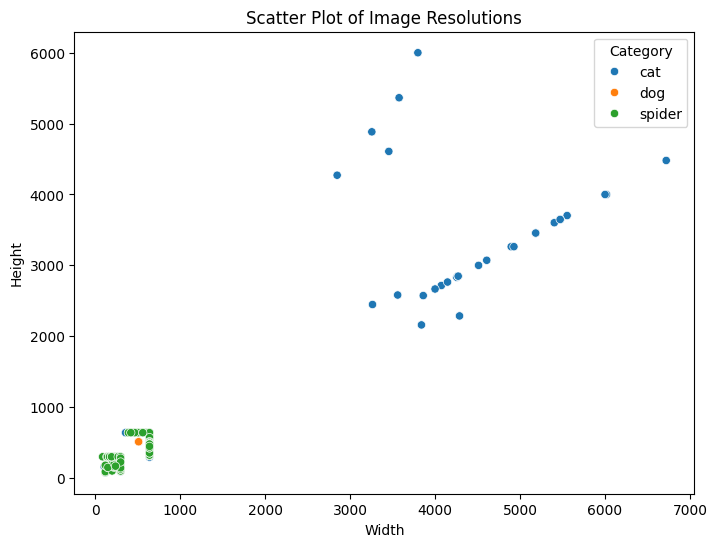

In [3]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=imageSizeDf, x="Width", y="Height", hue="Category")
plt.title("Scatter Plot of Image Resolutions")
plt.xlabel("Width")
plt.ylabel("Height")
plt.legend(title="Category")
plt.show()

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

base_dir = r"D:\Random_Projects\IDCamp\Proyek 2"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

IMG_SIZE = (128, 128)  #Resize images for uniformity
BATCH_SIZE = 32 #Batch Size for training


train_datagen = ImageDataGenerator(
    rescale=1.0/255, 
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

#Class Indices
class_names = list(train_generator.class_indices.keys())
print("Class Labels:", class_names)

Found 11292 images belonging to 3 classes.
Found 1410 images belonging to 3 classes.
Found 1413 images belonging to 3 classes.
Class Labels: ['cat', 'dog', 'spider']


In [1]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# from tensorflow.keras.layers import BatchNormalization
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import ReduceLROnPlateau

# # CNN Model
# model = Sequential([
#     Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', input_shape=(128, 128, 3)),
#     BatchNormalization(),
#     MaxPooling2D(2,2),

#     Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal'),
#     BatchNormalization(),
#     MaxPooling2D(2,2),

#     Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal'),
#     BatchNormalization(),
#     MaxPooling2D(2,2),

#     Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal'),  # Added extra depth
#     BatchNormalization(),
#     MaxPooling2D(2,2),

#     Flatten(),
#     Dense(1024, activation='relu', kernel_initializer='he_normal'),
#     Dropout(0.4),  # Regularization
#     Dense(3, activation='softmax')  # Make sure labels are one-hot encoded
# ])

# # Reduce learning rate when validation loss stops improving
# lr_scheduler = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.5,
#     patience=2,
#     min_lr=1e-6,
#     verbose=1
# )

# # Reduce initial learning rate
# model.compile(optimizer=Adam(learning_rate=0.0005), 
#               loss='categorical_crossentropy', 
#               metrics=['accuracy'])

# model.summary()

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# CNN Model
model = Sequential([
    Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal'),  # Added extra depth
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(1024, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.5),  # Regularization
    Dense(3, activation='softmax')  # Make sure labels are one-hot encoded
])

# Reduce learning rate when validation loss stops improving
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Reduce initial learning rate
model.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 128)      512       
 hNormalization)                                                 
                                                        

In [3]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[lr_scheduler]
)

Epoch 1/50
353/353 [==============================] - 61s 156ms/step - loss: 2.1046 - accuracy: 0.5091 - val_loss: 0.7731 - val_accuracy: 0.6447 - lr: 5.0000e-04
Epoch 2/50
353/353 [==============================] - 55s 154ms/step - loss: 0.8533 - accuracy: 0.6133 - val_loss: 0.6875 - val_accuracy: 0.6872 - lr: 5.0000e-04
Epoch 3/50
353/353 [==============================] - 57s 161ms/step - loss: 0.7636 - accuracy: 0.6613 - val_loss: 0.6260 - val_accuracy: 0.7482 - lr: 5.0000e-04
Epoch 4/50
353/353 [==============================] - 58s 165ms/step - loss: 0.6870 - accuracy: 0.7073 - val_loss: 0.5028 - val_accuracy: 0.7837 - lr: 5.0000e-04
Epoch 5/50
353/353 [==============================] - 59s 167ms/step - loss: 0.6317 - accuracy: 0.7388 - val_loss: 0.5468 - val_accuracy: 0.7617 - lr: 5.0000e-04
Epoch 6/50
353/353 [==============================] - 59s 167ms/step - loss: 0.5608 - accuracy: 0.7664 - val_loss: 0.4336 - val_accuracy: 0.8121 - lr: 5.0000e-04
Epoch 7/50
353/353 [========

In [4]:
#Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

45/45 [==============================] - 3s 62ms/step - loss: 0.1611 - accuracy: 0.9490
Test Accuracy: 0.9490
Test Loss: 0.1611


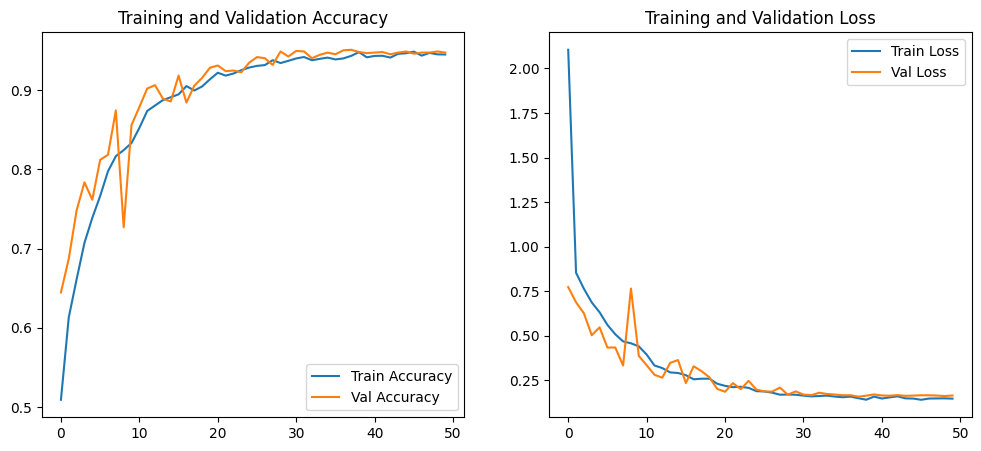

In [5]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

# Call function
plot_history(history)

In [6]:
model.save(os.path.join(base_dir, "saved_model"))
print("Model saved in SavedModel format.")

INFO:tensorflow:Assets written to: D:\Random_Projects\IDCamp\Proyek 2\saved_model\assets


INFO:tensorflow:Assets written to: D:\Random_Projects\IDCamp\Proyek 2\saved_model\assets


Model saved in SavedModel format.


In [7]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open(os.path.join(base_dir, "model.tflite"), "wb") as f:
    f.write(tflite_model)

print("Model saved as TF-Lite format.")

INFO:tensorflow:Assets written to: C:\Users\FATHAN~1\AppData\Local\Temp\tmpqs0m6opg\assets


INFO:tensorflow:Assets written to: C:\Users\FATHAN~1\AppData\Local\Temp\tmpqs0m6opg\assets


Model saved as TF-Lite format.


In [8]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.10.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
import tensorflowjs as tfjs

tfjs_target_dir = os.path.join(base_dir, "tfjs_model")
tfjs.converters.save_keras_model(model, tfjs_target_dir)

print("Model saved in TensorFlow.js format.")

Model saved in TensorFlow.js format.
